In [17]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns


In [105]:
path = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/%s/Results.txt'
path_annotation = '/home/juan/Desktop/juan/bio/mirna_mite/data/introns.gff3'
path_annotation_promoters = '/home/juan/Desktop/juan/bio/mirna_mite/data/promoters.gff3'
path_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.csv'
path_mirna_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.fasta'
path_mirna_seq_trep = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.trep.fasta'
path_mirna_mites_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.mites.y.fasta'
path_mirna_mature = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.mature.csv'
path_res_seq = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.fasta'
experiments = ['mrcv_mites','mrcv_all','sun_all','sun_mites']
path_genome = '/home/juan/Desktop/juan/bio/data/IWGSC/42/Triticum_aestivum.IWGSC.dna.toplevel.fa'
path_blast_res = '/home/juan/Desktop/juan/bio/mirna_mite/data/res/blast_mites.csv'
path_mirbase = '/home/juan/Desktop/juan/bio/mirna_mite/data/mature.fa'

In [106]:
### Load shortstack results
dfs = {}
for experiment in experiments:
    experiment_path = path % (experiment,)
    df = pd.read_csv(experiment_path, sep='\t')
    df['Name'] = experiment + '_' + df['Name']
    print('Experiment:', experiment)
    print('All results:',len(df.index))
    #df = df[df.MIRNA == 'Y']
    #print('Only miRNAs:',len(df.index))
    df = df[df.Reads > 15]
    print('Only miRNAs +20 reads:',len(df.index))
    df = df[df['21'] > 10]
    print('Only miRNAs 21nt +5 reads:',len(df.index))
    print('*' * 10)
    dfs[experiment] = df

Experiment: mrcv_mites
All results: 1211339
Only miRNAs +20 reads: 27597
Only miRNAs 21nt +5 reads: 1751
**********
Experiment: mrcv_all
All results: 38532
Only miRNAs +20 reads: 38532
Only miRNAs 21nt +5 reads: 10778
**********
Experiment: sun_all
All results: 157492
Only miRNAs +20 reads: 157492
Only miRNAs 21nt +5 reads: 44964
**********
Experiment: sun_mites
All results: 1211339
Only miRNAs +20 reads: 62212
Only miRNAs 21nt +5 reads: 3609
**********


In [107]:
dfs = [ v for v in dfs.values() ]

In [108]:
df = pd.concat(dfs)

In [109]:
len(df.index)

61102

In [110]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,DicerCall,MIRNA,PhaseScore,Short,Long,20,21,22,23,24
669,1A:7191963-7192334,mrcv_mites_MITE_T_7077|chr2B|403696383|4036967...,372,65,0.510,4,0.031,-,UUUUUUGUCGAGAGUUGCUCA,36,...,21,N15,-1.0,4,0,13,38,0,0,10
777,1A:8267612-8267880,mrcv_mites_MITE_T_22970|chr5A|493341243|493341...,269,122,0.957,9,0.361,.,AGUUUGACUUCGGAGAAUUCUAAU,25,...,24,N6,0.2,0,5,0,25,2,5,85


In [111]:
df['seqname'] = df['#Locus'].str.split(':').str[0]
df['position'] = df['#Locus'].str.split(':').str[1]
df['start'] = df.position.str.split('-').str[0].astype(int)
df['end'] = df.position.str.split('-').str[1].astype(int)

In [112]:
df = df.reset_index(drop=True)


In [113]:
print(len(df.index))

61102


In [114]:
df[df.index.isin(['876749','876750','876751','27433'])]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
27433,3B:262192194-262193584,sun_all_Cluster_55362,1391,457,3.619,302,0.341,.,UGGAAAAAUAUAGGAUGGCCGAAU,16,...,4,18,25,25,46,317,3B,262192194-262193584,262192194,262193584


In [115]:
min_distance = 60
duplicated = []
for k,v in df.iterrows():
    if k in duplicated:
        continue
    other = df[(df.index != k) & 
                (df.seqname == v.seqname) &
                (df.MajorRNA == v.MajorRNA) &
                (abs(df.start - v.start) <= min_distance) & 
                (abs(df.end - v.end) <= min_distance)]
    if len(other.index) > 0:
        duplicated += other.index.tolist()

In [116]:
duplicated = set(duplicated)
print(len(duplicated))

1757


In [117]:
print(len(df.index))

61102


In [118]:
df = df[~df.index.isin(duplicated)]
count_total = len(df.index)
count_total

59345

In [119]:
df.MIRNA.value_counts()

N6     28157
N11    10284
N2      8300
N5      7961
N14     1213
N12     1003
N13      997
N15      911
Y        260
N4       231
N8        28
Name: MIRNA, dtype: int64

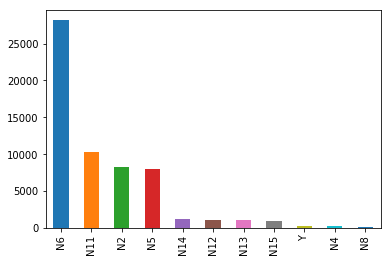

In [120]:
df.MIRNA.value_counts().plot('bar')

In [121]:
len(df[df.MIRNA == 'Y'].index)

260

In [122]:
df = df[df.MIRNA == 'Y']
print('Only miRNAs:',len(df.index))

Only miRNAs: 260


In [123]:
df.head(3)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,Long,20,21,22,23,24,seqname,position,start,end
125,1D:147896240-147896319,mrcv_mites_MITE_T_120271|chr2D|74975911|749759...,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,4,2,38,1,0,0,1D,147896240-147896319,147896240,147896319
223,2A:168984136-168984233,mrcv_mites_MITE_T_102616|chr1B|301273397|30127...,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,1,1,39,89,63,1,2A,168984136-168984233,168984136,168984233
510,3A:19302861-19302943,mrcv_mites_MITE_T_105526|chr3A|638201844|63820...,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,2,0,99,4,0,3,3A,19302861-19302943,19302861,19302943


In [124]:
df_mites = df[df.Name.str.contains('MITE')]
count_mites = len(df_mites.index)
count_mites

18

In [125]:
df_nomites = df[~df.Name.str.contains('MITE')]
count_nomites = len(df_nomites.index)
count_nomites

242

In [126]:
count_mites * 100 / count_total

0.030331114668464065

In [127]:
#get sequences
df.sort_values(['seqname', 'start'], inplace=True)


In [128]:
fasta_seq = SeqIO.parse(path_genome, 'fasta')
   

In [129]:
buffer_seqs = []
for record in fasta_seq:
    dff_extract = df[df.seqname == record.id]
    print(record.id, len(dff_extract.index))
    clean_seq = ''.join(str(record.seq).splitlines())
    for k,v in dff_extract.iterrows():
        start = min(v.start,v.end)
        end = max(v.start,v.end)
        new_seq = clean_seq[start:end]
        id = v.Name
        desc = record.id + "_" + str(start) + '_' + str(end)
        seq = SeqRecord(Seq(new_seq), id=id, description=desc)
        buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_res_seq, "fasta")
print(path_res_seq)

1A 5
1B 6
1D 6
2A 13
2B 18
2D 5
3A 10
3B 9
3D 11
4A 15
4B 8
4D 9
5A 20
5B 16
5D 20
6A 18
6B 17
6D 16
7A 14
7B 17
7D 5
Un 2
/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.fasta


In [130]:
path_res_seq

'/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.fasta'

In [131]:
df_trep = pd.read_csv(path_blast_res, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_trep.columns = cols
df_trep = df_trep[df_trep.pident >= 80]
df_trep = df_trep[df_trep.qcovs >= 80]
print(len(df_trep.index))
df_trep.head(2)

499


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,sun_all_Cluster_8835,MITE_1712,1,79,2,80,9,0,88.608,7.860000e-24,79,80,81,99,112
1,sun_all_Cluster_8835,MITE_233,3,77,4,78,8,4,84.416,1.330000e-14,77,80,80,94,78


In [132]:
len(df_trep.qseqid.unique())

28

In [133]:
df_trep['MITE'] = df_trep.groupby(['qseqid'])['sseqid'].transform(lambda x: ','.join(x))


In [134]:
df_trep = df_trep[['qseqid','MITE']]

In [135]:
df_trep.head(2)

,qseqid,MITE
0,sun_all_Cluster_8835,"MITE_1712,MITE_233,MITE_1717,MITE_1157"
1,sun_all_Cluster_8835,"MITE_1712,MITE_233,MITE_1717,MITE_1157"


In [136]:
df_trep = df_trep.drop_duplicates(subset=['qseqid'], keep='first')


In [137]:
df_trep.head(2)

,qseqid,MITE
0,sun_all_Cluster_8835,"MITE_1712,MITE_233,MITE_1717,MITE_1157"
61,mrcv_all_Cluster_2513,"MITE_1151,MITE_1572,MITE_1565,MITE_606,MITE_68..."


In [138]:
len(df_trep.index)

28

In [139]:
df = pd.merge(df, df_trep, how='left', left_on='Name', right_on='qseqid')

In [140]:
df.drop("qseqid", axis=1, inplace=True)

In [141]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,20,21,22,23,24,seqname,position,start,end,MITE
0,1A:309399489-309399664,mrcv_all_Cluster_872,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,35,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN
1,1A:309399491-309399581,sun_all_Cluster_2789,91,459,3.635,4,0.007,-,ACGGCAUAGAGGCACUGCAAA,196,...,94,298,26,0,5,1A,309399491-309399581,309399491,309399581,NaN


In [142]:
total_count = len(df.index)
total_count

260

In [143]:
df_new_not_mites = df[df.MITE.isnull()]
count_not_mites = len(df_new_not_mites.index)
count_not_mites

232

In [144]:
df_new_mites = df[df.MITE.notnull()]
count_mites = len(df_new_mites.index)
count_mites

28

In [145]:
count_mites * 100 / total_count

10.76923076923077

In [146]:
#mirbase

In [147]:
buffer_seqs = []
for k,v in df.iterrows():
    id = v.Name
    desc = v['#Locus']
    seq = SeqRecord(Seq(v.MajorRNA), id=id, description=desc)
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq, "fasta")
print(len(buffer_seqs))
print(path_mirna_seq)

260
/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.fasta


In [188]:
buffer_seqs = []
for k,v in df[df.MITE.notnull()].iterrows():
    id = v.Name
    desc = v['#Locus']
    if "|" in id:
        id = id.split("|")[0]
    seq = SeqRecord(Seq(v.MajorRNA), id=id, description="")
    buffer_seqs.append(seq)
SeqIO.write(buffer_seqs, path_mirna_seq_trep, "fasta")
print(len(buffer_seqs))
print(path_mirna_seq_trep)

28
/home/juan/Desktop/juan/bio/mirna_mite/data/res/mirna.y.trep.fasta


In [151]:
df_mirbase = pd.read_csv(path_mirna_mature, sep="\t")
cols = ['qseqid','sseqid','qstart','qend','sstart','send','mismatch','gaps','pident','evalue','length','qlen','slen','qcovs','score']
df_mirbase.columns = cols
print(len(df_mirbase.index))
df_mirbase.head(2)

17928


,qseqid,sseqid,qstart,qend,sstart,send,mismatch,gaps,pident,evalue,length,qlen,slen,qcovs,score
0,sun_all_Cluster_2789,ptc-miR1447,10,20,16,6,0,0,100.0,1.2,11,21,21,52,22
1,mrcv_all_Cluster_1015,tca-miR-6017-5p,5,15,10,20,0,0,100.0,1.3,11,22,20,50,22


In [152]:
allowed_mirbase_mismatches = 7
mirbase_qlen = 7

In [153]:
df_mirbase = df_mirbase[df_mirbase.length > df_mirbase.qlen - mirbase_qlen]
print(len(df_mirbase.index))


16592


In [154]:
df_mirbase = df_mirbase[df_mirbase.mismatch + df_mirbase.gaps <= allowed_mirbase_mismatches]
print(len(df_mirbase.index))


16592


In [155]:
len(df_mirbase.qseqid.unique().tolist())


164

In [156]:
df_mirbase = df_mirbase[['qseqid','sseqid']]


In [157]:
df_mirbase['mirbase'] = df_mirbase.groupby(['qseqid'])['sseqid'].transform(lambda x: ','.join(x))


In [158]:
df_mirbase = df_mirbase[['qseqid','mirbase']]

In [159]:
df_mirbase = df_mirbase.drop_duplicates(subset=['qseqid'], keep='first')


In [160]:
print(len(df_mirbase.index))
df_mirbase.head(2)

164


,qseqid,mirbase
14,sun_all_Cluster_8835,hvu-miR6197
20,mrcv_all_Cluster_2061,"aof-miR166d,cas-miR166f-3p,cas-miR166d,cas-miR..."


In [161]:
df = pd.merge(df, df_mirbase, how='left', left_on='Name', right_on='qseqid')

In [162]:
df.drop("qseqid", axis=1, inplace=True)

In [163]:
df.head(2)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:309399489-309399664,mrcv_all_Cluster_872,176,553,4.340,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN
1,1A:309399491-309399581,sun_all_Cluster_2789,91,459,3.635,4,0.007,-,ACGGCAUAGAGGCACUGCAAA,196,...,298,26,0,5,1A,309399491-309399581,309399491,309399581,NaN,NaN


In [164]:
len(df.index)

260

In [165]:
#genomic annotation

In [166]:
df_ann = pd.read_csv(path_annotation, index_col=False, sep='\t', comment='#', header=None)
df_ann.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']


In [167]:
print(len(df_ann.index))


2573211


In [168]:
df_ann = df_ann[
    (df_ann.feature == 'intron') | 
    (df_ann.feature == 'exon') | 
    (df_ann.feature == 'three_prime_UTR') | 
    (df_ann.feature == 'five_prime_UTR')]
print(len(df_ann.index))


1593666


In [169]:
df_ann_promoters = pd.read_csv(path_annotation_promoters, index_col=False, sep='\t', comment='#', header=None)
df_ann_promoters.columns = ['seqname' , 'source' , 'feature' , 'start' , 'end' , 'score' , 'strand' , 'frame' , 'attribute']
print(len(df_ann_promoters.index))


120744


In [170]:
df_ann_total = pd.concat([df_ann, df_ann_promoters])


In [171]:
df_ann_total.head(2)

,seqname,source,feature,start,end,score,strand,frame,attribute
2,1A,Ensembl_Plants,exon,200,1683,.,+,.,Parent=transcript:ENSRNA050013875-T1;Name=ENSR...
5,1A,Ensembl_Plants,exon,5023,6833,.,+,.,Parent=transcript:ENSRNA050013847-T1;Name=ENSR...


In [172]:
len(df_ann_total.index)


1714410

In [173]:
df_anns = {}
for chromosome in df_ann_total.seqname.unique():
    df_anns[chromosome] = df_ann_total[df_ann_total.seqname == chromosome]


In [174]:
df.head(1)

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,21,22,23,24,seqname,position,start,end,MITE,mirbase
0,1A:309399489-309399664,mrcv_all_Cluster_872,176,553,4.34,1,0.002,-,ACGGCAUAGAGGCACUGCAAA,327,...,440,61,5,4,1A,309399489-309399664,309399489,309399664,NaN,NaN


In [175]:
df['annotation'] = 'intergenic'

In [176]:
for k,v in df.iterrows():
    other = df_anns[v.seqname]
    other = other[(other.end >= v.start) & (other.start <= v.end)]
    if len(other.index) > 0:
        features = set(other.feature.tolist())
        str_features = ', '.join(features)
        if df.loc[k, 'annotation'] == 'three_prime_UTR' or df.loc[k, 'annotation'] == 'five_prime_UTR':
            continue
        df.loc[k, 'annotation'] = str_features

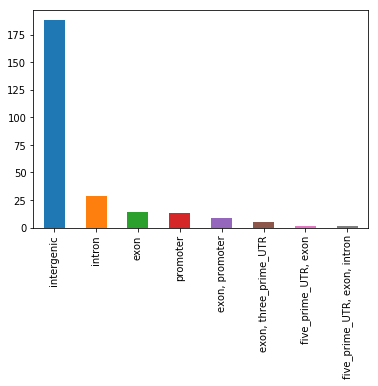

In [177]:
df.annotation.value_counts().plot('bar')

In [178]:
#let's have some fun with data

In [179]:
df[df.MITE.notnull()].annotation.value_counts()

intron                   14
intergenic               10
promoter                  2
exon, three_prime_UTR     2
Name: annotation, dtype: int64

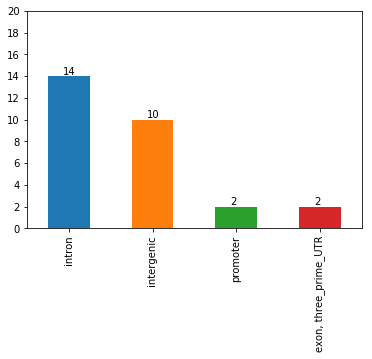

In [187]:
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot
ax = df[df.MITE.notnull()].annotation.value_counts().plot('bar')
x_offset = -0.07
y_offset = 0.15
ax.set_ylim(0,20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

for p in ax.patches:
    b = p.get_bbox()
    val = int(b.y1)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
ax
pyplot.savefig('../data/res/1.png',transparent=True, bbox_inches='tight', pad_inches=0)

In [181]:
len(df.index)

260

In [182]:
print(len(df[df.MITE.notnull()].index))
df[df.MITE.notnull()]

28


,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
5,1B:161992200-161992280,sun_all_Cluster_8835,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,0,0,2,1B,161992200-161992280,161992200,161992280,"MITE_1712,MITE_233,MITE_1717,MITE_1157",hvu-miR6197,intron
9,1B:565664575-565664794,mrcv_all_Cluster_2513,220,223,1.750,1,0.991,+,CAUUUUCCUAUAGACUUGGUC,142,...,7,0,0,1B,565664575-565664794,565664575,565664794,"MITE_1151,MITE_1572,MITE_1565,MITE_606,MITE_68...",NaN,intron
11,1D:147896240-147896319,mrcv_mites_MITE_T_120271|chr2D|74975911|749759...,80,45,0.353,1,1.000,+,UAUAUUUUGGUACGGAGGGAU,22,...,1,0,0,1D,147896240-147896319,147896240,147896319,"MITE_1717,MITE_1717,MITE_233,MITE_233,MITE_18,...",NaN,intron
17,2A:133702671-133702770,sun_mites_MITE_T_99232|chr3B|765723509|7657236...,100,2289,18.126,2181,0.983,+,UGAGACGGGUAAUUUGGAACGGAG,1484,...,53,101,2001,2A,133702671-133702770,133702671,133702770,"DTT_Tmon_Icarus_BG607724-1,DTT_Tmon_Icarus_BG6...",NaN,promoter
20,2A:168984136-168984233,mrcv_mites_MITE_T_102616|chr1B|301273397|30127...,98,198,1.554,2,0.045,-,UCGGAAUUAGUUGACACUCAAA,86,...,89,63,1,2A,168984136-168984233,168984136,168984233,"MITE_253,MITE_253,MITE_293,MITE_1428,DTT_Taes_...",NaN,intron
30,2B:5671327-5671460,sun_all_Cluster_28681,134,562,4.450,504,0.016,-,UAUCUGGACAAAUCUGAGACA,293,...,5,2,4,2B,5671327-5671460,5671327,5671460,"MITE_798,MITE_798,MITE_148,MITE_148,DTT_Hvul_P...",NaN,intron
37,2B:482720682-482720772,sun_all_Cluster_33132,91,102,0.808,91,0.078,-,AUCUUCUAUCGUGGGACGAAG,48,...,1,1,1,2B,482720682-482720772,482720682,482720772,"MITE_1444,MITE_1444,MITE_1030,MITE_1030,DTT_Ta...",NaN,intron
44,2B:720801630-720801713,mrcv_all_Cluster_8534,84,505,3.963,486,1.000,+,AUUGAACUAAGGAGGGGUGGA,386,...,5,0,0,2B,720801630-720801713,720801630,720801713,"MITE_1643,MITE_1643",NaN,intron
53,3A:19302861-19302943,mrcv_mites_MITE_T_105526|chr3A|638201844|63820...,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,4,0,3,3A,19302861-19302943,19302861,19302943,"MITE_1128,MITE_1128,MITE_792,MITE_792,MITE_975...",tae-miR5175-5p,intron
62,3A:746087222-746087306,mrcv_all_Cluster_12767,85,181,1.421,16,0.000,-,UAAUAUGGAUUGGAGGGGGUA,74,...,3,5,13,3A,746087222-746087306,746087222,746087306,MITE_660,oan-miR-1400-3p,"exon, three_prime_UTR"


In [183]:
#list(df[df.MITE.notnull()].MITE.unique())

In [184]:
df[(df.MITE.notnull()) & (df.mirbase.notnull())]

,#Locus,Name,Length,Reads,RPM,UniqueReads,FracTop,Strand,MajorRNA,MajorRNAReads,...,22,23,24,seqname,position,start,end,MITE,mirbase,annotation
5,1B:161992200-161992280,sun_all_Cluster_8835,81,135,1.069,5,0.919,+,UCUGUUCACAAAUGUAAGACG,106,...,0,0,2,1B,161992200-161992280,161992200,161992280,"MITE_1712,MITE_233,MITE_1717,MITE_1157",hvu-miR6197,intron
53,3A:19302861-19302943,mrcv_mites_MITE_T_105526|chr3A|638201844|63820...,83,108,0.848,10,0.972,+,UCCAAUUACUCGUCGUGGUUU,89,...,4,0,3,3A,19302861-19302943,19302861,19302943,"MITE_1128,MITE_1128,MITE_792,MITE_792,MITE_975...",tae-miR5175-5p,intron
62,3A:746087222-746087306,mrcv_all_Cluster_12767,85,181,1.421,16,0.000,-,UAAUAUGGAUUGGAGGGGGUA,74,...,3,5,13,3A,746087222-746087306,746087222,746087306,MITE_660,oan-miR-1400-3p,"exon, three_prime_UTR"
122,5A:552632192-552632284,mrcv_mites_MITE_T_95924|chr2B|774087848|774087...,93,46,0.361,0,0.000,-,UGCGGCACUUAUUUUGGGACG,40,...,0,0,0,5A,552632192-552632284,552632192,552632284,"MITE_1338,MITE_1338,MITE_180,DTT_Tdur_Hades_29...","hvu-miR5049c,bdi-miR5181a-3p",intergenic
237,7B:34679825-34679952,mrcv_mites_MITE_T_80536|chr6D|312104065|312104...,128,184,1.444,26,0.989,+,UGUCGUAGAUUUGUCUAGAUA,99,...,0,1,14,7B,34679825-34679952,34679825,34679952,"MITE_1548,MITE_1548,MITE_677,MITE_677,DTT_Taes...",hvu-miR6191,intergenic


In [185]:
df[df.MITE.notnull()][['#Locus','Name','MajorRNA','MITE','annotation','mirbase']]

,#Locus,Name,MajorRNA,MITE,annotation,mirbase
5,1B:161992200-161992280,sun_all_Cluster_8835,UCUGUUCACAAAUGUAAGACG,"MITE_1712,MITE_233,MITE_1717,MITE_1157",intron,hvu-miR6197
9,1B:565664575-565664794,mrcv_all_Cluster_2513,CAUUUUCCUAUAGACUUGGUC,"MITE_1151,MITE_1572,MITE_1565,MITE_606,MITE_68...",intron,NaN
11,1D:147896240-147896319,mrcv_mites_MITE_T_120271|chr2D|74975911|749759...,UAUAUUUUGGUACGGAGGGAU,"MITE_1717,MITE_1717,MITE_233,MITE_233,MITE_18,...",intron,NaN
17,2A:133702671-133702770,sun_mites_MITE_T_99232|chr3B|765723509|7657236...,UGAGACGGGUAAUUUGGAACGGAG,"DTT_Tmon_Icarus_BG607724-1,DTT_Tmon_Icarus_BG6...",promoter,NaN
20,2A:168984136-168984233,mrcv_mites_MITE_T_102616|chr1B|301273397|30127...,UCGGAAUUAGUUGACACUCAAA,"MITE_253,MITE_253,MITE_293,MITE_1428,DTT_Taes_...",intron,NaN
30,2B:5671327-5671460,sun_all_Cluster_28681,UAUCUGGACAAAUCUGAGACA,"MITE_798,MITE_798,MITE_148,MITE_148,DTT_Hvul_P...",intron,NaN
37,2B:482720682-482720772,sun_all_Cluster_33132,AUCUUCUAUCGUGGGACGAAG,"MITE_1444,MITE_1444,MITE_1030,MITE_1030,DTT_Ta...",intron,NaN
44,2B:720801630-720801713,mrcv_all_Cluster_8534,AUUGAACUAAGGAGGGGUGGA,"MITE_1643,MITE_1643",intron,NaN
53,3A:19302861-19302943,mrcv_mites_MITE_T_105526|chr3A|638201844|63820...,UCCAAUUACUCGUCGUGGUUU,"MITE_1128,MITE_1128,MITE_792,MITE_792,MITE_975...",intron,tae-miR5175-5p
62,3A:746087222-746087306,mrcv_all_Cluster_12767,UAAUAUGGAUUGGAGGGGGUA,MITE_660,"exon, three_prime_UTR",oan-miR-1400-3p


In [186]:
df.to_csv(path_res, sep='\t', index=None)
print(len(df.index))
print(path_res)

260
/home/juan/Desktop/juan/bio/mirna_mite/data/res/all_results.csv
